# Rest leser

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

import geopandas as gpd


def query_map_service(service_url, where='1=1', fields='*', crs=4326):
    # Define the query endpoint
    query_url = f"{service_url}/query"

    # Determine the total number of records for the given where clause
    count_params = {
        "where": where,
        "returnCountOnly": True,
        "f": "json"
    }
    tot_records_json = requests.get(query_url, params=count_params).json()
    tot_records = tot_records_json["count"]

    # Determine the step size for pages
    step_json = requests.get(service_url, params={'f': 'json'}).json()
    step = step_json["maxRecordCount"]

    # Define query parameters
    query_params = {
        "where": where,
        "outFields": ', '.join(fields) if isinstance(fields, list) else fields,
        "outSr": crs,
        "f": "geojson",
        "orderByFields": "OBJECTID",
        "returnGeometry": True,
        "resultRecordCount": step
    }

    # Loop through each page of query results concurrently
    with ThreadPoolExecutor(max_workers=4) as ex:
        futures = []
        for offset in range(0, tot_records, step):
            # Create each offset query
            query_params['resultOffset'] = offset
            offset_query = urllib.parse.urlencode(query_params)
            offset_query_url = f"{query_url}?{offset_query}"

            # Submit each query to the thread
            submit = ex.submit(gpd.read_file, offset_query_url)
            futures.append(submit)

        # Compile all futures once they're complete
        gdfs = [f.result() for f in as_completed(futures)]

    # Concatenate the resulting dataframes
    gdf = gpd.pd.concat(gdfs, ignore_index=True)

    return gdf

# Nettverksanalyser

In [1]:
# load packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#import arcpy
import os
import scipy as scipy
import pandas as pd
from scipy.linalg import eig
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances


pd.set_option('display.max_columns', None)
np.set_printoptions(precision=20)

def distanceMatrix(xy):
    return(squareform(pdist(xy)))


# Function to calculate distances, both Euclidian and "realised"/"Experienced" distances, where the latter is a probability output
def calculate_distance_matrix(input_feature_class, Alpha = 1/1000, ExportLines = False):
    """
    This function calculates a distance matrix for all points in the input feature class using NumPy arrays.
    
    :param input_feature_class: Path to the input feature class containing point geometries.
    :return: A NumPy array representing the distance matrix.
    """
    # Retrieve the spatial reference of the input feature class.
    sr = arcpy.Describe(input_feature_class).spatialReference

    # Get the number of points in the input feature class.
    point_count = int(arcpy.GetCount_management(input_feature_class).getOutput(0))

    # Initialize a NumPy array to store the distance matrix with zeros.
    distance_matrix = np.zeros((point_count, point_count))
    # Initialize a NumPy array to store the dispersal probabilities.
    distance_matrix_exp = np.zeros((point_count, point_count))

    # Create a list to store geometries and their IDs.
    geometries = []    
    
    # Here we have chunk where we create a feature class where we can store the lines going btw all the features
    # Define the spatial reference
    spatial_ref = arcpy.Describe(input_feature_class).spatialReference
    
    # Use a search cursor to iterate through the features and store geometries.
    with arcpy.da.SearchCursor(input_feature_class, ["OID@", "SHAPE@"], spatial_reference=sr) as cursor:
        for row in cursor:
            oid, geom = row
            geometries.append((oid, geom))

    # Calculate distances and fill the NumPy array.
    for i, (oid_from, geom_from) in enumerate(geometries):
        #print(i)
        for j, (oid_to, geom_to) in enumerate(geometries):
            if oid_from != oid_to:  # Ensure that we don't calculate the distance to the same feature.
                distance = geom_from.distanceTo(geom_to)  # Calculate the distance to another feature.
                distance_matrix[i, j] = distance  # Store the calculated distance in the array.
                distance_matrix_exp[i, j] = np.exp(-distance*Alpha)  # Store the calculated distance in the array.
                #if ExportLines is True
                    # Create a new feature class
                    #new_feature_class = 'Paths'
                    #arcpy.CreateFeatureclass_management(arcpy.env.workspace, new_feature_class, 'POLYLINE', spatial_reference=spatial_ref)
                    #start_point = geom_from.centroid # now we move over to generating lines btw all the geometries
                #    end_point = geom_to.centroid  #  this lines are later used to illustrate sensitities of the connections
                #    line = arcpy.Polyline(arcpy.Array([start_point, end_point]), spatial_ref) # create a line
                #    # TODO: Add OID
                #    # Use an insert cursor to add the new line to the feature class
                #    with arcpy.da.InsertCursor(new_feature_class, ['SHAPE@']) as cursor:
                #        cursor.insertRow([line])

    return distance_matrix, distance_matrix_exp  # Return the complete distance matrix.

def calculate_areas_and_outer_matrix(feature_class):
    """
    Calculate the areas of features in a feature class and the outer product matrix of these areas.
    
    :param feature_class: Path to the input feature class.
    :return: A tuple containing a list of areas and the outer product matrix.
    """
    # Step 1: Extract Areas
    areas = []
    with arcpy.da.SearchCursor(feature_class, ["SHAPE@AREA"]) as cursor:
        for row in cursor:
            areas.append(row[0])  # Append the area of the feature to the list

    # Step 2: Create Outer Matrix
    areas_array = np.array(areas)  # Convert the list of areas to a NumPy array
    outer_matrix = np.outer(areas_array, areas_array)  # Calculate the outer product matrix

    return areas, outer_matrix

# Main function
def CalcEigenmeasures(LandscapeMatrix, IDs=None):
    # If IDs is not provided, create an enumerated index
    if IDs is None:
        IDs = np.arange(LandscapeMatrix.shape[0])
    
    # Define the function to calculate contribution
    def calculate_contribution(Lambda, Mij):
        num_patches = Mij.shape[0]
        contributions = np.zeros(num_patches)
        
        for ii in range(num_patches):
            # Exclude the ii-th row and column from Mij
            Mij_sub = np.delete(Mij, ii, axis=0)
            Mij_sub = np.delete(Mij_sub, ii, axis=1)
            
            # Calculate the largest eigenvalue of the modified Mij
            eigenvalues = np.linalg.eigvals(Mij_sub)
            largest_eigenvalue = np.max(eigenvalues)
            
            # Calculate the contribution
            contributions[ii] = (Lambda - largest_eigenvalue) / Lambda
        
        return contributions

    eigenvalues, eigenvectors = scipy.linalg.eig(LandscapeMatrix)
    Le = np.argmax(eigenvalues)
    Lambda = np.real(eigenvalues[Le])
    
    # Approximate stable age distribution = right eigenvector
    w0 = np.real(eigenvectors[:, Le])
    w = np.abs(w0)
    # Reproductive value = left eigenvector
    # This equals the right eigenvector of the landscape matrix transposed
    V = np.linalg.inv(eigenvectors).conj()
    v = np.abs(np.real(V[Le, ]))
    
    # Contribution of the patch to lambda
    # When considering small perturbations, loses a small part of the habitats and habitat degradation
    pc = v.T * w  # These are normalized
    # pc_small = pc / np.sum(pc)  # Normalize the contributions

    # 'pc_s' now contains the normalized contribution of each patch to lambda
    # Call the function with your Lambda and Mij data
    contributions = calculate_contribution(Lambda, LandscapeMatrix)

    # Collect all the measures
    EigenMeasures = pd.DataFrame({"ID": IDs,
                                  "PC_small": pc,
                                  "PC_large": contributions,
                                  "REv": w, 
                                  "LEv": v})
    return EigenMeasures

def communities(landscape_matrix):
    # Convert the input matrix to a NumPy array
    M = np.array(landscape_matrix)
    # Calculate the total number of edges/links in the landscape
    m = np.sum(M > 0)
    
    # Calculate the degrees of the vertices/nodes/patches
    kj = np.sum(M > 0, axis=0)
    ki = np.sum(M > 0, axis=1)
    
    # Define the modularity matrix
    B = M - np.outer(ki, kj) / (2 * m)
    # Compute the eigenvalues and eigenvectors of the modularity matrix
    ev = np.linalg.eig(B)
    
    # Find the index of the largest eigenvalue
    lmax = np.argmax(np.real(ev[0]))
    
    # Get the eigenvector corresponding to the largest eigenvalue
    W = ev[1][:, lmax]
    
    # Create a frame with indices and group labels based on the sign of the eigenvector
    w_frame = np.column_stack((np.arange(len(W)), np.array([chr(97 + int(x)) for x in np.sign(W) + 1])))
    # Generate positions for the nodes for visualization
    #pos = nx.spring_layout(nx.from_numpy_matrix(M))
    
    # Plot the nodes with colors based on their group labels
    #plt.scatter(*zip(*pos.values()), c=[ord(x) for x in w_frame[:, 1]])
    #plt.show()
    print("Run loop")
    t = 0
    while len(np.unique(w_frame[:, t])) != len(np.unique(w_frame[:, t + 1])):
        print(t)
        new_col = np.empty(len(w_frame), dtype=object)
        
        for i in np.unique(w_frame[:, t + 1]):
            idx = np.where(w_frame[:, t + 1] == i)[0]
            subB = B[np.ix_(idx, idx)]
            ev = np.linalg.eig(subB)
            lmax = np.argmax(np.real(ev[0]))
            W = ev[1][:, lmax]
            new_col[idx] = [f"{w_frame[idx[0], t + 1]}-{chr(97 + int(x))}" for x in np.sign(W) + 1]
        
        w_frame = np.column_stack((w_frame, new_col))
        #w_frame[:, t + 1] = np.array([ord(x) for x in w_frame[:, t + 1]])
        # Convert the first column of characters to numbers starting from 1
        unique_chars, indices = np.unique(w_frame[:, t + 1], return_inverse=True)
        w_frame[:, t + 1] = indices + 1
        t += 1
    
    return w_frame[:, :-1]


In [ ]:
# If a simple function is wanted
# Generate random positions
#pos = np.vstack([
    #np.column_stack((np.random.uniform(18, 30, 10), np.random.uniform(20, 30, 10))),
    #np.column_stack((np.random.uniform(35, 45, 10), np.random.uniform(50, 60, 10))),
    #np.column_stack((np.random.uniform(170, 190, 10), np.random.uniform(170, 190, 10))),
    #np.column_stack((np.random.uniform(170, 190, 10), np.random.uniform(20, 40, 10))),
    #np.column_stack((np.random.uniform(120, 140, 10), np.random.uniform(120, 140, 10)))
#])

# Plot the positions
#plt.scatter(pos[:, 0], pos[:, 1])
#plt.show()

In [ ]:
# Calculate the distance matrix
#M = squareform(pdist(pos))
# Apply the exponential transformation
#M0 = np.exp(-M * (1/30))
# Set the diagonal to zero
#np.fill_diagonal(M0, 0)
#results = communities(M0)
#print(results.shape[1])
#print(results)
#sizes = np.random.uniform(4, 30, len(M0))
# Step 2: Create Outer Matrix
#areas_array = sizes
#outer_matrix = np.outer(areas_array, areas_array)  # Calculate the outer product matrix
#dists = distanceMatrix(pos)
#realizedDists = np.exp(-dists*.5)
#ij = realizedDists*outer_matrix
# set diagonal to zero
#np.fill_diagonal(Mij, 0)
#Mij
#print(np.arange(Mij.shape[0]))
#tmp = EigenCentrality(Mij)
#print(tmp)

In [ ]:
from scipy.spatial import ConvexHull
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot each scatter plot in its respective subplot
axs[0, 0].scatter(pos[:, 0], pos[:, 1], cmap='viridis')
axs[0, 0].set_title('Alle')

axs[0, 1].scatter(pos[:, 0], pos[:, 1], c=results[:,1], cmap='viridis')
axs[0, 1].set_title('Først oppdeling')

axs[1, 0].scatter(pos[:, 0], pos[:, 1], c=results[:,2], cmap='viridis')
axs[1, 0].set_title('Andre oppdeling')

# Get unique groups
unique_groups = np.unique(results[:,int(results.shape[1])-1])

axs[1, 1].scatter(pos[:, 0], pos[:, 1], c=results[:,int(results.shape[1])-1], cmap='viridis')
axs[1, 1].set_title(f"{len(unique_groups)} forskjellige grupper" )


# Add convex hull or polygon around each group
for group in unique_groups:
    group_points = pos[results[:,int(results.shape[1])-1] == group]
    if len(group_points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(group_points)
        for simplex in hull.simplices:
            plt.plot(group_points[simplex, 0], group_points[simplex, 1], 'k-')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Nettverkfunksjonssammensatt

In [3]:
#import arcpy

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
import scipy as scipy
from scipy import stats
from scipy.linalg import eig
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from joblib import Parallel, delayed

import leafmap.foliumap as leafmap
import folium

In [4]:
# Function to calculate distance matrix
def distanceMatrix(xy):
    return squareform(pdist(xy))
# Function to calculate polygon distances
def polygon_distance_matrix(gdf):
    n = len(gdf)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = gdf.geometry.iloc[i].distance(gdf.geometry.iloc[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

# Function to read the feature class or use the pre-loaded GeoDataFrame
def read_or_use_gdf(input_data):
    if isinstance(input_data, str):
        return read_feature_class(input_data)  # Assuming read_feature_class is defined elsewhere
    elif isinstance(input_data, gpd.GeoDataFrame):
        return input_data
    else:
        raise ValueError("Input must be a file path or a GeoDataFrame")
# Function to read the feature class based on file extension

def read_feature_class(file_path):
    file_extension = os.path.splitext(file_path)[1].lower()
    if file_extension == '.gpkg':
        gdf = gpd.read_file(file_path, layer=0)
    elif file_extension == '.gdb':
        gdf = gpd.read_file(file_path, driver='FileGDB', layer="GRUK")
       # gdf = gpd.read_file(file_path, driver='FileGDB', layer="0")
    else:
        raise ValueError("Unsupported file format. Please provide a GeoPackage (.gpkg) or File Geodatabase (.gdb).")
    return gdf


def calculate_landscapematrix(file_path_or_gdf, use_centroid=True, decay_factor=1/1500):
    # Read the feature class or use the provided GeoDataFrame
    gdf = read_or_use_gdf(file_path_or_gdf)

    if use_centroid:
        # Calculate the centroid coordinates
        gdf = gdf.copy()
        gdf['coordinates'] = gdf.geometry.centroid
        xy = np.array(list(zip(gdf.coordinates.x, gdf.coordinates.y)))
        # Ensure xy is a 2-dimensional array
        if xy.ndim != 2 or xy.shape[1] != 2:
            raise ValueError("Coordinates array 'xy' must be a 2-dimensional array with shape (n, 2).")
        # Calculate distance matrix using centroids
        dists = distanceMatrix(xy)
    else:
        # Calculate distance matrix using polygons
        dists = polygon_distance_matrix(gdf)

    # Calculate the areas of the geometries
    sizes = gdf.geometry.area
    # Create Outer Matrix
    outer_matrix = np.outer(sizes, sizes)  # Calculate the outer product matrix
    # Calculate realized distances with the decay factor
    realizedDists = np.exp(-dists * decay_factor)
    # Calculate Mij
    Mij = realizedDists * outer_matrix
    # Set diagonal to zero
    np.fill_diagonal(Mij, 0)

    return Mij

def eigenMeasures(matrix):
    eigenvalues, eigenvectors = scipy.linalg.eig(matrix)
    Le = np.argmax(eigenvalues)
    Lambda = np.real(eigenvalues[Le])
    
    # Approximate stable age distribution = right eigenvector
    w0 = np.real(eigenvectors[:, Le])
    w = np.abs(w0)
    # Reproductive value = left eigenvector
    # This equals the right eigenvector of the landscape matrix transposed
    V = np.linalg.inv(eigenvectors).conj()
    v = np.abs(np.real(V[Le, ]))
    return Lambda, w, v

# Function to calculate the contribution, parallelized inside
def calculate_contribution(Lambda, Mij):
    num_patches = Mij.shape[0]

    def contribution_for_patch(ii):
        try:
            Mij_sub = np.delete(Mij, ii, axis=0)
            Mij_sub = np.delete(Mij_sub, ii, axis=1)
            eigenvalues = np.linalg.eigvals(Mij_sub)
            largest_eigenvalue = np.max(eigenvalues)
            return np.real((Lambda - largest_eigenvalue) / Lambda)
        except np.linalg.LinAlgError:
            print(f"Singular matrix encountered for patch index {ii}")
            return np.nan

    contributions = Parallel(n_jobs=-1)(delayed(contribution_for_patch)(ii) for ii in range(num_patches))
    return contributions


def EigenCentrality(LandscapeMatrix=None, geometry=None, use_centroid=True, decay_factor=1/1500, IDs=None):
    if LandscapeMatrix is None and geometry is not None:
        LandscapeMatrix = calculate_landscapematrix(geometry, use_centroid, decay_factor)
    
    if LandscapeMatrix is None:
        raise ValueError("Either LandscapeMatrix or geometry must be provided.")
    
    # If IDs is not provided, create an enumerated index
    if IDs is None:
        IDs = np.arange(LandscapeMatrix.shape[0])  
       
    Lambda, w, v = eigenMeasures(LandscapeMatrix)
    
    # Contribution of the patch to lambda
    # When considering small perturbations, loses a small part of the habitats and habitat degradation
    pc = v.T * w  # These are normalized

    # Call the function with your Lambda and Mij data
    #contributions = calculate_contribution(Lambda, LandscapeMatrix)
    contributions = calculate_contribution(Lambda, LandscapeMatrix)
    # Collect all the measures
    EigenMeasures = pd.DataFrame({"ID": IDs,
                                  "PC_small": pc,
                                  "PC_large": contributions,
                                  "REv": w, 
                                  "LEv": v})    
    return EigenMeasures

def communities(LandscapeMatrix=None, geometry=None, use_centroid=True, decay_factor=1/1500):
    if LandscapeMatrix is None and geometry is not None:
        LandscapeMatrix = calculate_landscapematrix(geometry, use_centroid, decay_factor)
    
    if LandscapeMatrix is None:
        raise ValueError("Either LandscapeMatrix or geometry must be provided.")
    
    # Convert the input matrix to a NumPy array
    M = np.array(LandscapeMatrix)
    # Calculate the total number of edges/links in the landscape
    m = np.sum(M > 0)
    
    # Calculate the degrees of the vertices/nodes/patches
    kj = np.sum(M > 0, axis=0)
    ki = np.sum(M > 0, axis=1)
    
    # Define the modularity matrix
    B = M - np.outer(ki, kj) / (2 * m)
    # Compute the eigenvalues and eigenvectors of the modularity matrix
    ev = np.linalg.eig(B)
    
    # Find the index of the largest eigenvalue
    lmax = np.argmax(np.real(ev[0]))
    
    # Get the eigenvector corresponding to the largest eigenvalue
    W = ev[1][:, lmax]
    
    # Create a frame with indices and group labels based on the sign of the eigenvector
    w_frame = np.column_stack((np.arange(len(W)), np.array([chr(97 + int(x)) for x in np.sign(W) + 1])))
    # Generate positions for the nodes for visualization
    #pos = nx.spring_layout(nx.from_numpy_matrix(M))
    
    # Plot the nodes with colors based on their group labels
    #plt.scatter(*zip(*pos.values()), c=[ord(x) for x in w_frame[:, 1]])
    #plt.show()
    print("Run loop")
    t = 0
    while len(np.unique(w_frame[:, t])) != len(np.unique(w_frame[:, t + 1])):
        new_col = np.empty(len(w_frame), dtype=object)
        
        for i in np.unique(w_frame[:, t + 1]):
            idx = np.where(w_frame[:, t + 1] == i)[0]
            subB = B[np.ix_(idx, idx)]
            ev = np.linalg.eig(subB)
            lmax = np.argmax(np.real(ev[0]))
            W = ev[1][:, lmax]
            new_col[idx] = [f"{w_frame[idx[0], t + 1]}-{chr(97 + int(x))}" for x in np.sign(W) + 1]
        
        w_frame = np.column_stack((w_frame, new_col))
        #w_frame[:, t + 1] = np.array([ord(x) for x in w_frame[:, t + 1]])
        # Convert the first column of characters to numbers starting from 1
        unique_chars, indices = np.unique(w_frame[:, t + 1], return_inverse=True)
        w_frame[:, t + 1] = indices + 1
        t += 1
    
    return w_frame[:, :-1]
   
def calculate_landscapematrix_with_add_par(file_path, use_centroid=True, decay_factor=1/1500, file_path_add=None):
    Mij = calculate_landscapematrix(file_path, use_centroid, decay_factor)

    if file_path_add is not None:
        gdf_add = read_or_use_gdf(file_path_add)
        gdf = read_or_use_gdf(file_path)

        Mij_list = []
        
        for idx, add_row in enumerate(gdf_add.itertuples(), start=1):
            if use_centroid:
                add_coords = add_row.geometry.centroid
                add_dists = np.array([add_coords.distance(pt) for pt in gdf['coordinates']])
            else:
                add_dists = np.array([add_row.geometry.distance(poly) for poly in gdf.geometry])

            realizedDists_add = np.exp(-add_dists * decay_factor)
            Mij_add = realizedDists_add * gdf.geometry.area * add_row.geometry.area
            Mij_add = np.column_stack((np.vstack((Mij, Mij_add)), np.append(Mij_add, 0)))
            Mij_list.append(Mij_add)

        Mij_list.insert(0, Mij)

        # Vectorized computation of eigenmeasures
        a, _, _ = eigenMeasures(Mij_list[0])
        res = Parallel(n_jobs=-1)(delayed(lambda i: eigenMeasures(Mij_list[i])[0] - a)(i) for i in range(len(Mij_list)))

        return Mij_list, res
    else:
        return [Mij]



def categorize_percentiles(df, value, group=None, thresholds=[1/3, 2/3]):
    if not thresholds:
        raise ValueError("Thresholds list must not be empty")
    
    thresholds = sorted(thresholds)

    # Function to categorize based on percentiles
    def assign_category(x, bins):
        for i, t in enumerate(bins):
            if x <= t:
                return i
        return len(bins)
    
    if group:
        # Calculate percentiles group-wise
        df['percentile'] = df.groupby(group)[value].transform(
            lambda x: pd.cut(x, bins=[-np.inf] + [np.quantile(x, t) for t in thresholds] + [np.inf], labels=False)
        )
    else:
        # Calculate percentiles for the entire dataset
        bins = [-np.inf] + [np.quantile(df[value], t) for t in thresholds] + [np.inf]
        df['percentile'] = pd.cut(df[value], bins=bins, labels=False)
    
    # Assign categories based on percentiles
    df['category'] = df['percentile'].apply(lambda x: f'Category_{assign_category(x, range(len(thresholds) + 1)) + 1}')
    
    # Ensure 'category' is an ordered categorical type
    category_order = [f'Category_{i + 1}' for i in range(len(thresholds) + 1)]
    df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
    
    return df

def rgb_to_hex(rgb):
    """
    Convert an RGB color to a hex color.
    
    Parameters:
    rgb (tuple): A tuple containing the RGB values (each ranging from 0 to 1).
    
    Returns:
    str: The hex color string.
    """
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))


In [19]:
import geopandas as gpd
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from joblib import Parallel, delayed
import scipy.linalg
import os

class EigenNetworkAnalysis:
    def __init__(self, input_data, use_centroid=True, decay_factor=1/1500):
        self.gdf = self.read_or_use_gdf(input_data)
        self.use_centroid = use_centroid
        self.decay_factor = decay_factor
        self.Mij = None
        self.check_crs()

    def read_or_use_gdf(self, input_data):
        if isinstance(input_data, str):
            return self.read_feature_class(input_data)
        elif isinstance(input_data, gpd.GeoDataFrame):
            return input_data
        else:
            raise ValueError("Input must be a file path or a GeoDataFrame")

    def read_feature_class(self, file_path):
        file_extension = os.path.splitext(file_path)[1].lower()
        if file_extension == '.gpkg':
            return gpd.read_file(file_path, layer=0)
        elif file_extension == '.gdb':
            return gpd.read_file(file_path, driver='FileGDB', layer="GRUK")
        else:
            raise ValueError("Unsupported file format. Please provide a GeoPackage (.gpkg) or File Geodatabase (.gdb).")

    def check_crs(self):
        if self.gdf.crs is None or not self.gdf.crs.is_projected:
            raise ValueError("The GeoDataFrame must have a projected coordinate system with units in meters.")
        if 'metre' not in self.gdf.crs.axis_info[0].unit_name.lower():
            raise ValueError("The GeoDataFrame must use meters as the unit of measurement.")

    def calculate_landscapematrix(self):
        if self.use_centroid:
            self.gdf['coordinates'] = self.gdf.geometry.centroid
            xy = np.array(list(zip(self.gdf.coordinates.x, self.gdf.coordinates.y)))
            dists = squareform(pdist(xy))
        else:
            dists = self.polygon_distance_matrix(self.gdf)

        sizes = self.gdf.geometry.area
        outer_matrix = np.outer(sizes, sizes)
        realizedDists = np.exp(-dists * self.decay_factor)
        self.Mij = realizedDists * outer_matrix
        np.fill_diagonal(self.Mij, 0)

    def polygon_distance_matrix(self, gdf):
        n = len(gdf)
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                dist = gdf.geometry.iloc[i].distance(gdf.geometry.iloc[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

    def eigenMeasures(self):
        eigenvalues, eigenvectors = scipy.linalg.eig(self.Mij)
        Le = np.argmax(eigenvalues)
        Lambda = np.real(eigenvalues[Le])
        w0 = np.real(eigenvectors[:, Le])
        w = np.abs(w0)
        V = np.linalg.inv(eigenvectors).conj()
        v = np.abs(np.real(V[Le, ]))
        return Lambda, w, v

    def calculate_contribution(self, Lambda):
        num_patches = self.Mij.shape[0]

        def contribution_for_patch(ii):
            try:
                Mij_sub = np.delete(self.Mij, ii, axis=0)
                Mij_sub = np.delete(Mij_sub, ii, axis=1)
                eigenvalues = np.linalg.eigvals(Mij_sub)
                largest_eigenvalue = np.max(eigenvalues)
                return np.real((Lambda - largest_eigenvalue) / Lambda)
            except np.linalg.LinAlgError:
                print(f"Singular matrix encountered for patch index {ii}")
                return np.nan

        contributions = Parallel(n_jobs=-1)(delayed(contribution_for_patch)(ii) for ii in range(num_patches))
        return contributions

    def calculate_eigen_measures(self):
        Lambda, w, v = self.eigenMeasures()
        contributions = self.calculate_contribution(Lambda)
        eigen_measures_df = pd.DataFrame({
            "ID": np.arange(self.Mij.shape[0]),
            "PC_small": v.T * w,
            "PC_large": contributions,
            "REv": w,
            "LEv": v
        })
        self.gdf = self.gdf.reset_index(drop=True)
        self.gdf = pd.concat([self.gdf, eigen_measures_df], axis=1)

    def estimate_communities(self):
        M = np.array(self.Mij)
        m = np.sum(M > 0)
        kj = np.sum(M > 0, axis=0)
        ki = np.sum(M > 0, axis=1)
        B = M - np.outer(ki, kj) / (2 * m)
        ev = np.linalg.eig(B)
        lmax = np.argmax(np.real(ev[0]))
        W = ev[1][:, lmax]
        w_frame = np.column_stack((np.arange(len(W)), np.array([chr(97 + int(x)) for x in np.sign(W) + 1])))
        t = 0
        while len(np.unique(w_frame[:, t])) != len(np.unique(w_frame[:, t + 1])):
            new_col = np.empty(len(w_frame), dtype=object)
            for i in np.unique(w_frame[:, t + 1]):
                idx = np.where(w_frame[:, t + 1] == i)[0]
                subB = B[np.ix_(idx, idx)]
                ev = np.linalg.eig(subB)
                lmax = np.argmax(np.real(ev[0]))
                W = ev[1][:, lmax]
                new_col[idx] = [f"{w_frame[idx[0], t + 1]}-{chr(97 + int(x))}" for x in np.sign(W) + 1]
            w_frame = np.column_stack((w_frame, new_col))
            unique_chars, indices = np.unique(w_frame[:, t + 1], return_inverse=True)
            w_frame[:, t + 1] = indices + 1
            t += 1
        communities_df = pd.DataFrame(w_frame[:, :-1], columns=["Community"])
        self.gdf = pd.concat([self.gdf, communities_df], axis=1)

    def calculate_landscapematrix_with_add_par(self, file_path_add):
        Mij_list = []
        gdf_add = self.read_or_use_gdf(file_path_add)
        for idx, add_row in enumerate(gdf_add.itertuples(), start=1):
            if self.use_centroid:
                add_coords = add_row.geometry.centroid
                add_dists = np.array([add_coords.distance(pt) for pt in self.gdf['coordinates']])
            else:
                add_dists = np.array([add_row.geometry.distance(poly) for poly in self.gdf.geometry])

            realizedDists_add = np.exp(-add_dists * self.decay_factor)
            Mij_add = realizedDists_add * self.gdf.geometry.area * add_row.geometry.area
            Mij_add = np.column_stack((np.vstack((self.Mij, Mij_add)), np.append(Mij_add, 0)))
            Mij_list.append(Mij_add)

        Mij_list.insert(0, self.Mij)
        a, _, _ = self.eigenMeasures()
        res = Parallel(n_jobs=-1)(delayed(lambda i: self.eigenMeasures(Mij_list[i])[0] - a)(i) for i in range(len(Mij_list)))
        return Mij_list, res

    def run_analysis(self, estimate_communities=False, use_alternative=False, file_path_add=None):
        if use_alternative and file_path_add:
            self.Mij, _ = self.calculate_landscapematrix_with_add_par(file_path_add)
        else:
            self.calculate_landscapematrix()
        self.calculate_eigen_measures()
        if estimate_communities:
            self.estimate_communities()
        return self.gdf

# Example usage
# analysis = EigenNetworkAnalysis("path/to/your/file.gpkg")
# result_gdf = analysis.run_analysis(estimate_communities=True, use_alternative=True, file_path_add="path/to/additional/file.gpkg")

In [23]:
analysis = EigenNetworkAnalysis(skogVO)
if skogFVO is not None and not skogFVO.empty:
	result_gdf = analysis.run_analysis(estimate_communities=True, use_alternative=True, file_path_add=skogFVO)
else:
	result_gdf = analysis.run_analysis(estimate_communities=True, use_alternative=False)

ValueError: The truth value of a GeoDataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [18]:
# if self.gdf.crs is None or not self.gdf.crs.is_projected:
#            raise ValueError("The GeoDataFrame must have a projected coordinate system with units in meters.")
skogVO.crs.axis_info[0].unit_name.lower()

'metre'

In [79]:
eig_sVO = EigenCentrality(geometry=skogVO)

In [ ]:
s1 = eigenMeasures(calculate_landscapematrix(skogVO, decay_factor=1/2000))[0]
tmp = skogVO.drop(28)
s2 = eigenMeasures(calculate_landscapematrix(tmp, decay_factor=1/2000))[0]
tmp = skogVO.drop(18)
s3 = eigenMeasures(calculate_landscapematrix(tmp, decay_factor=1/2000))[0]

print(s1>s2)
print(s2>s3)
print(np.real((s1 - s2) / s1))
print(np.real((s1 - s3) / s1))

In [ ]:
sVO_g = communities(calculate_landscapematrix(tmp, decay_factor=1/2000))
sVO_g

In [ ]:
eig_sVO

### Verneområder

In [9]:
VO = gpd.read_file("C:/Data/Vern_0000_norge_25833_FILEGDB.gdb", layer = 1)
skogVO = VO.loc[(VO["verneform"]=="naturreservat") & (VO["verneplan"].str.contains("skog"))]
FVO = gpd.read_file("C:/Data/ForeslattVern_0000_norge_25833_FILEGDB.gdb", layer = 0)
skogFVO = FVO.loc[(FVO["verneform"]=="naturreservat") & (FVO["verneplan"].str.contains("skog"))]


In [13]:
skogVO.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.01, 84.42)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:

# Example usage
#file_path = 'C:/Users/endofs/OneDrive - Miljødirektoratet/Dokumenter/ArcGIS/Projects/MyProject/MyProject.gdb'
#a = calculate_landscapematrix(file_path, use_centroid=True, decay_factor=1/1500)
#print(a)

# Example usage with geometry file path
#geometry_path = 'C:/Users/endofs/OneDrive - Miljødirektoratet/Dokumenter/ArcGIS/Projects/MyProject/MyProject.gdb'
#eigen_measures_df = CalcEigenmeasures(geometry=geometry_path, use_centroid=True, decay_factor=1/1500)
#print(eigen_measures_df)

In [ ]:
_,res = calculate_landscapematrix_with_add_par(file_path=skogVO, file_path_add=skogFVO, decay_factor=1/1500)
#from scipy import stats
#stats.describe(alts[1][:,1363])

In [ ]:
#a,_,_ = eigenMeasures(alts[0])
#res = []
#for i in alts:
#    b,_,_ = eigenMeasures(i)
#    print(b)
#    res.append(b-a)
#    
#skogFVO["mcValue"]=[float(i) for i in res[1:]]# subsetter vekk først element da det er det opprinnelige

In [ ]:
skogFVO["mcValue"]=res[1:]

In [77]:
skog_e = EigenCentrality(geometry = skogVO)

In [ ]:
skog_e

In [ ]:
df = categorize_percentiles(skogFVO, "mcValue")
df.groupby("category")["mcValue"].median()

In [ ]:

# Define the number of categories
n_categories = df['category'].nunique()

# Generate a colormap using matplotlib
cmap = plt.get_cmap('viridis', n_categories)

# Create a dictionary to map categories to colors
color_map = {}
for i, category in enumerate(pd.Categorical(df["category"]).categories):
    rgba = cmap(i)
    color = 'rgb({},{},{})'.format(int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))
    color = rgb_to_hex(rgba[:3])
    color_map[category] = color

# Function to get the color for each feature
def get_color(category):
    return color_map[category]

# Create the base map
m = leafmap.Map(location=[62.64, 8], tiles="OpenStreetMap", zoom_start=10)

# Convert GeoDataFrame to EPSG 4326
df = df.to_crs(epsg=4326)

# Iterate through the GeoDataFrame and add each feature to the map
for _, r in df.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    fill_color = get_color(r["category"])
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x, fill_color=fill_color: {"fillColor": fill_color, "color": "black", "weight": 1, "fillOpacity": 0.7})
    folium.Popup(r["navn"]).add_to(geo_j)
    geo_j.add_to(m)

# Define legend
legend_dict = {category: color for category, color in color_map.items()}

# Add legend to the map
m.add_legend(title="Category Legend", legend_dict=legend_dict)

# Display the map
m

In [ ]:
origs = calculate_landscapematrix_with_add_par(file_path=skogVO, decay_factor=1/1500)

In [ ]:
CalcEigenmeasures(origs[0])

In [ ]:
### TODO
### Noe feil her Mij og Mij_add er like
orig = np.real(np.max(np.linalg.eigvals(alts[0])))
# Calculate the largest eigenvalue of the modified Mij
effs = [(y := np.real(np.linalg.eigvals(x)),
  # Calculate the contribution
  (np.max(y)) - orig) for x in alts]          


#### Verduie

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_patch_values(coords, areas, y_vec, x_vec, f_ex, f_im, f_em, dispersal_kernel, locations):
    """
    Computes the value of multiple new patch locations.
    
    Parameters:
    - coords: Array of shape (n, 2) with coordinates of existing patches.
    - areas: Array of shape (n,) with areas of existing patches.
    - y_vec: Array of shape (n,) with left eigenvector components.
    - x_vec: Array of shape (n,) with right eigenvector components.
    - f_ex, f_im, f_em: Scaling parameters.
    - dispersal_kernel: Function that takes distances and returns kernel values.
    - locations: Array of shape (m, 2) with the coordinates of candidate locations.

    Returns:
    - An array of shape (m,) with the values for each candidate location.
    """
    # Prepare areas raised to powers for efficiency
    areas_fex_fim = areas ** (f_ex + f_im)
    areas_fem = areas ** f_em
    
    # Initialize result array
    values = np.zeros(len(locations))
    
    for i, location in enumerate(locations):
        # Compute distances from the current location to all patches
        distances = np.sqrt(((coords - location) ** 2).sum(axis=1))
        
        # Apply the dispersal kernel to distances
        dispersal_values = dispersal_kernel(distances)
        
        # Compute the two summation terms
        term1 = np.sum(y_vec * areas_fex_fim * dispersal_values)
        term2 = np.sum(x_vec * areas_fem * dispersal_values)
        
        # Compute the value for the current location
        values[i] = term1 * term2
    
    return values

if __name__ == "__main__":
    # Example data
    patch_coords = np.array([[1, 1], [2, 3], [4, 5]])  # Coordinates of existing patches
    patch_areas = np.array([10, 20, 15])              # Areas of existing patches
    
    left_eigenvector = np.array([0.5, 0.3, 0.2])      # Left eigenvector
    right_eigenvector = np.array([0.4, 0.35, 0.25])   # Right eigenvector
    
    scaling_f_ex, scaling_f_im, scaling_f_em = 0.8, 0.5, 0.5  # Scaling parameters
    
    # Define the dispersal kernel
    def dispersal_kernel(distances):
        alpha = 0.1  # Parameter controlling dispersal
        return np.exp(-alpha * distances)
    
    # Candidate locations to evaluate
    candidate_locations = np.array([[3, 3], [1, 4], [5, 5]])
    
    # Compute patch values for all locations
    patch_values = compute_patch_values(patch_coords, patch_areas, left_eigenvector, right_eigenvector, 
                                        scaling_f_ex, scaling_f_im, scaling_f_em, dispersal_kernel, 
                                        candidate_locations)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Plot existing patches in grey
    plt.scatter(patch_coords[:, 0], patch_coords[:, 1], s=patch_areas * 10, c='grey', alpha=0.6, label="Existing Patches")
    
    # Plot candidate locations in red
    max_value = np.max(patch_values)
    plt.scatter(candidate_locations[:, 0], candidate_locations[:, 1], 
                s=patch_values / max_value * 200,  # Size proportional to value
                c='red', alpha=patch_values / max_value, label="Candidate Locations")
    
    # Add labels and legend
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Patch Values of Candidate Locations")
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()


### Klynger

In [ ]:
def communities(LandscapeMatrix=None, geometry=None, use_centroid=True, decay_factor=1/1500):
    if LandscapeMatrix is None and geometry is not None:
        LandscapeMatrix = calculate_landscapematrix(geometry, use_centroid, decay_factor)
    
    if LandscapeMatrix is None:
        raise ValueError("Either LandscapeMatrix or geometry must be provided.")
    
    # Convert the input matrix to a NumPy array
    M = np.array(LandscapeMatrix)
    # Calculate the total number of edges/links in the landscape
    m = np.sum(M > 0)
    
    # Calculate the degrees of the vertices/nodes/patches
    kj = np.sum(M > 0, axis=0)
    ki = np.sum(M > 0, axis=1)
    
    # Define the modularity matrix
    B = M - np.outer(ki, kj) / (2 * m)
    # Compute the eigenvalues and eigenvectors of the modularity matrix
    ev = np.linalg.eig(B)
    
    # Find the index of the largest eigenvalue
    lmax = np.argmax(np.real(ev[0]))
    
    # Get the eigenvector corresponding to the largest eigenvalue
    W = ev[1][:, lmax]
    
    # Create a frame with indices and group labels based on the sign of the eigenvector
    w_frame = np.column_stack((np.arange(len(W)), np.array([chr(97 + int(x)) for x in np.sign(W) + 1])))
    # Generate positions for the nodes for visualization
    #pos = nx.spring_layout(nx.from_numpy_matrix(M))
    
    # Plot the nodes with colors based on their group labels
    #plt.scatter(*zip(*pos.values()), c=[ord(x) for x in w_frame[:, 1]])
    #plt.show()
    print("Run loop")
    t = 0
    while len(np.unique(w_frame[:, t])) != len(np.unique(w_frame[:, t + 1])):
        new_col = np.empty(len(w_frame), dtype=object)
        
        for i in np.unique(w_frame[:, t + 1]):
            idx = np.where(w_frame[:, t + 1] == i)[0]
            subB = B[np.ix_(idx, idx)]
            ev = np.linalg.eig(subB)
            lmax = np.argmax(np.real(ev[0]))
            W = ev[1][:, lmax]
            new_col[idx] = [f"{w_frame[idx[0], t + 1]}-{chr(97 + int(x))}" for x in np.sign(W) + 1]
        
        w_frame = np.column_stack((w_frame, new_col))
        #w_frame[:, t + 1] = np.array([ord(x) for x in w_frame[:, t + 1]])
        # Convert the first column of characters to numbers starting from 1
        unique_chars, indices = np.unique(w_frame[:, t + 1], return_inverse=True)
        w_frame[:, t + 1] = indices + 1
        t += 1
    
    return w_frame[:, :-1]

In [ ]:
comms_measures_df = communities(geometry=geometry_path, use_centroid=True, decay_factor=1/1500)
print(comms_measures_df)

In [ ]:
aa = read_feature_class(geometry_path)

In [ ]:
tt = aa.merge(eigen_measures_df, how = "left")

In [ ]:
pd.DataFrame(data = comms_measures_df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(tt['Centroid_X'], tt['Centroid_Y'], c=tt['PC_large'].astype('category').cat.codes, cmap='viridis')

# Add a legend
legend1 = ax.legend(*scatter.legend_elements(), title="col")
ax.add_artist(legend1)

# Set labels and title
ax.set_xlabel('cX')
ax.set_ylabel('cY')
ax.set_title('Scatter plot colorized by column "col"')

# Show the plot
plt.show()

### Tilfeldig landskap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

# Function to generate spatially autocorrelated points
def generate_spatially_autocorrelated_points(n_points, autocorrelation_func, size=(100, 100)):
    # Generate initial random points
    points = np.random.rand(n_points, 2) * size
    
    # Calculate distance matrix
    dist_matrix = distance_matrix(points, points)
    
    # Apply autocorrelation function to the distance matrix to get weights
    weights = autocorrelation_func(dist_matrix)
    
    # Adjust points based on weights to introduce spatial autocorrelation
    for i in range(n_points):
        points[i] = np.average(points, axis=0, weights=weights[i])
    
    return points

# Define Gaussian autocorrelation function
def gaussian_autocorrelation(dist_matrix, sigma=10):
    return np.exp(-dist_matrix**2 / (2 * sigma**2))

# Generate points with Gaussian spatial autocorrelation
n_points = 50
pos = generate_spatially_autocorrelated_points(n_points, gaussian_autocorrelation)

# Plot the points
plt.scatter(pos[:, 0], pos[:, 1], cmap='viridis')
plt.colorbar(label='Point Index')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatially Autocorrelated Points with Gaussian Noise')
plt.show()

# Kjerneområder fra raster

Om man vil ekstrahere f.eks. 95 % kjerneområder fra raster.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import rasterio

def raster_to_polygon(raster_path, perc, nodata_value=-9999):
    # Read raster data
    print("Read raster data")
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1, masked = True)
        transform = src.transform
        
    print("Convert and rinse")
    # Mask NoData values
    raster_data = np.ma.masked_equal(raster_data, nodata_value)
    # Flatten and filter out NaN values
    values = raster_data.flatten()
    coords = [(x, y) for x in range(raster_data.shape[1]) 
                   for y in range(raster_data.shape[0])]
    df = pd.DataFrame({'coordinates': coords, 'values': values})
    df = df.dropna()

    # Sort according to values in descending order
    df = df.sort_values(by='values', ascending=False)

    # Calculate cumulative sum divided by total sum
    df['cumsum'] = df['values'].cumsum() / df['values'].sum()

    # Filter according to the given percentile
    thr = perc / 100
    filtered_df = df[df['cumsum'] <= thr]
    
    print("Convert to GDF")

    # Convert the resulting points to a GeoDataFrame
    filtered_df['geometry'] = filtered_df['coordinates'].apply(lambda coord: Point(
                          transform * coord))
    gdf_points = gpd.GeoDataFrame(filtered_df, geometry='geometry')
    print("Filter and convert to polygon")

    # Create a convex hull polygon
    polygon = gdf_points.geometry.unary_union.convex_hull

    return polygon

# Example of usage
raster_path = 'c:/data/tile_8_wc2.1_30s_elev.tif'
#perc = 50  # Example percentage
polygon = raster_to_polygon(raster_path, perc = 50)



Read raster data
Convert and rinse
Convert to GDF


C:\Users\endre\AppData\Local\Temp\ipykernel_18308\1494030321.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['geometry'] = filtered_df['coordinates'].apply(lambda coord: Point(


Filter and convert to polygon


In [2]:
# Read raster data
print("Read raster data")
nodata_value = -32768
with rasterio.open(raster_path) as src:
    raster_data = src.read(1, masked = False)
    transform = src.transform
        
print("Convert and rinse")
# Mask NoData values
raster_data = np.ma.masked_equal(raster_data, nodata_value)
print(raster_data)


Read raster data
Convert and rinse
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [14 27 41 ... 211 211 210]
 [9 17 25 ... 209 210 211]
 [0 0 0 ... 210 217 217]]


In [3]:
import rasterio
import numpy as np
import pandas as pd

# Open the raster dataset
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1, masked=True)
    
    # Replace specific values (e.g., -32768) with NA (masked values)
    raster_data = np.ma.masked_equal(raster_data, -32768)
    
    # Flatten the raster data to create a vector, including NA values
    values = raster_data.flatten()
    
    # Create coordinates
    coords = [(x, y) for y in range(raster_data.shape[0])
              for x in range(raster_data.shape[1])]
    
    # Create a DataFrame
    df = pd.DataFrame({'coordinates': coords, 'values': values})
    
    # Explicitly set masked values to NaN
    df['values'] = df['values'].apply(lambda x: np.nan if x is np.ma.masked else x)

# Sort according to values in descending order
df = df.sort_values(by='values', ascending=False)

# Calculate cumulative sum divided by total sum
df['cumsum'] = df['values'].cumsum() / df['values'].sum()

# Filter according to the given percentile
perc = 5
thr = perc / 100

# TODO: Filter the DataFrame based on the threshold
# BUT IT DOES NOT WORK YET!
# Pseudo code:
# 1 - extract the values column
# 2 - set the values to NaN where cumsum is greater than the threshold
# 3 - update the values array with NaNs where necessary
# 4 - reshape the vector back into the original 2D array
# 5 - create a new raster with the updated values
# 6 - return the new raster
# 7 - plot the new raster

import scipy.stats as stats
print("Orig values with NaNs:", stats.describe(values))
# Set values to NaN where CumSum is greater than the threshold
df.loc[df['cumsum'] > thr, 'values'] = np.nan

# Update the values array with NaNs where necessary
new_values = np.ma.masked_where(df['cumsum'] > thr, values)
#new_values = new_values['values']
# Print the updated values
print("Updated values with NaNs:", stats.describe(values))

Orig values with NaNs: DescribeResult(nobs=12960000, minmax=(-32768, 1655), mean=-23136.295720679012, variance=224294025.65455118, skewness=0.9118284163727293, kurtosis=-1.1684795958479093)
Updated values with NaNs: DescribeResult(nobs=12960000, minmax=(-32768, 1655), mean=-23136.295720679012, variance=224294025.65455118, skewness=0.9118284163727293, kurtosis=-1.1684795958479093)


In [13]:
import rasterio
import numpy as np
import pandas as pd

# Open the raster dataset
with rasterio.open(raster_path) as src:
    # Read the NoData value from the raster metadata
    nodata_value = src.nodata
    SRtransform = src.transform
    raster_crs = src.crs
    bounds = src.bounds  # Get the bounds of the raster
    # Read the raster data
    raster_data = src.read(1, masked=True)
    # Replace specific values (NoData value) with NA (masked values)
    raster_data = np.ma.masked_equal(raster_data, nodata_value)
        
    # Flatten the raster data to create a vector, including NA values
    values = raster_data.flatten()#.astype(float)  # Convert to float to allow NaN
    
    # Create coordinates
    #coords = [(x, y) for y in range(raster_data.shape[0])
    #          for x in range(raster_data.shape[1])]
    
    # Create a DataFrame
    #df = pd.DataFrame({'coordinates': coords, 'values': values})
    
    # Explicitly set masked values to NaN
    #df['values'] = df['values'].apply(lambda x: np.nan if x is np.ma.masked else x)
df = pd.DataFrame({'coordinates': coords, 'values': values})

# Sort according to values in descending order
df = df.sort_values(by='values', ascending=False)

# Calculate cumulative sum divided by total sum
df['CumSum'] = df['values'].cumsum()/np.sum(values)
# Filter according to the given percentile
perc = 0.2
thr = perc #/ 100
#print(df[df['CumSum'] > thr])
# Set values to NaN where CumSum is greater than the threshold
df.loc[df['CumSum'] > thr, 'values'] = np.nan
print(df.head(9))
# Update the values array with NaNs where necessary
#new_values = values.copy()
#new_values[df.index[df['cumsum'] > thr]] = nodata_value
df = df.sort_index()
df


           coordinates  values    CumSum
10821599  (3599, 3005)  1655.0  0.000003
10846793  (3593, 3012)  1608.0  0.000006
10839584  (3584, 3010)  1566.0  0.000008
10825199  (3599, 3006)  1560.0  0.000011
10839573  (3573, 3010)  1558.0  0.000014
10817998  (3598, 3004)  1538.0  0.000017
10843185  (3585, 3011)  1536.0  0.000019
10864782  (3582, 3017)  1532.0  0.000022
10864783  (3583, 3017)  1532.0  0.000025


,coordinates,values,CumSum
0,"(0, 0)",NaN,NaN
1,"(1, 0)",NaN,NaN
2,"(2, 0)",NaN,NaN
3,"(3, 0)",NaN,NaN
4,"(4, 0)",NaN,NaN
...,...,...,...
12959995,"(3595, 3599)",NaN,0.389186
12959996,"(3596, 3599)",NaN,0.380215
12959997,"(3597, 3599)",NaN,0.369365
12959998,"(3598, 3599)",NaN,0.347770


In [5]:
tmp = np.array(df['values'])
tmp[np.isnan(tmp)] = nodata_value
tmp = tmp.astype(int)
# Create a masked array where values equal to -1 are masked
new_values = np.ma.masked_where(tmp == nodata_value, tmp)
print(stats.describe(new_values[new_values>0]))

DescribeResult(nobs=231492, minmax=(306, 1655), mean=492.5213441501218, variance=32489.643612661195, skewness=1.3437663999404743, kurtosis=1.691509323749833)


In [6]:
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.features import shapes
from shapely.geometry import shape, mapping
import geopandas as gpd

# Reshape the vector back into the original 2D array
rows, cols = raster_data.shape
reshaped_raster_data = new_values.reshape((rows, cols))


In [7]:
import numpy as np
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape

def array_to_polygons(array, affine=None):
    """
    Returns a geopandas dataframe of polygons as deduced from an array.

    :param array: The 2D numpy array to polygonize.
    :param affine: The affine transformation.
    :return: GeoDataFrame with polygons and raster values.
    """
    # Check if affine transformation is provided
    if affine is None:
        # Generate shapes without affine transformation
        results = [
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(array, connectivity=8))
        ]
    else:
        # Generate shapes with affine transformation
        results = [
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(array, transform=affine, connectivity=8))
        ]

    # Create a GeoDataFrame from the shapes and properties
    tops_df = gpd.GeoDataFrame({
        'geometry': [shape(results[geom]['geometry']) for geom in range(len(results))],
        'raster_val': [results[geom]['properties']['raster_val'] for geom in range(len(results))]
    })

    # Set the geometry column
    tops_df = tops_df.set_geometry('geometry')

    # Set the CRS of the GeoDataFrame (assuming raster_crs is defined elsewhere)
    tops_df = tops_df.set_crs(raster_crs)

    return tops_df

In [8]:
polys = array_to_polygons(reshaped_raster_data,SRtransform)

<Axes: >

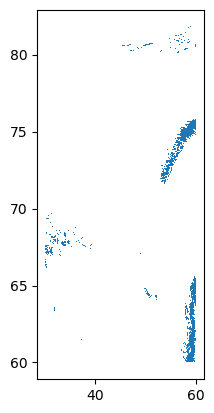

In [9]:
polys.plot()

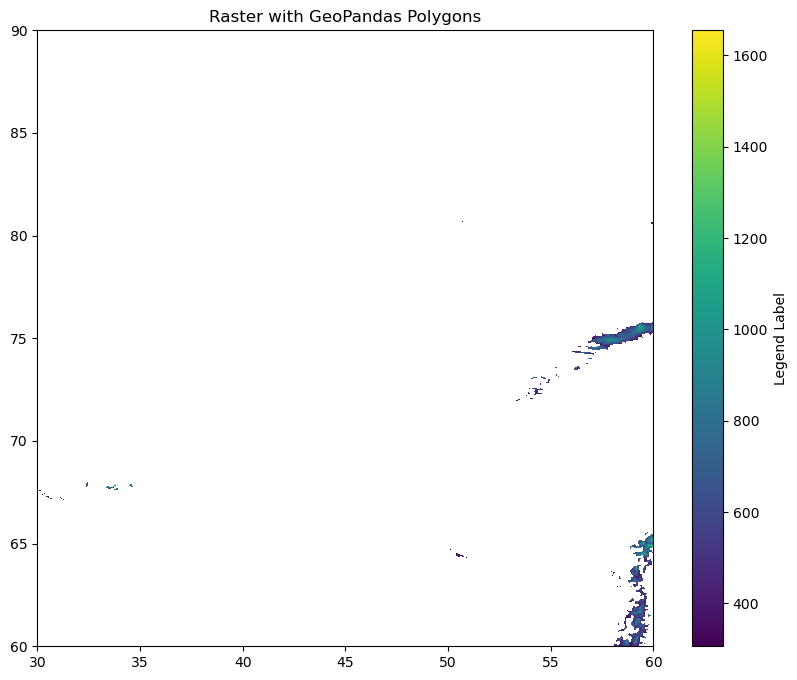

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the raster data
img = ax.imshow(reshaped_raster_data, cmap='viridis', extent=src.bounds, origin='upper')
ax.set_title('Raster with GeoPandas Polygons')

# Add a colorbar as a legend
cbar = plt.colorbar(img, ax=ax, orientation='vertical')
cbar.set_label('Legend Label')  # Set the label for the colorbar

# Plot the GeoPandas polygons on top of the raster
polys.plot(ax=ax, facecolor='none', edgecolor='red')

plt.show()

In [16]:
import folium
import io
from PIL import Image
import base64  # Import the base64 module

# Create a folium map centered on the raster
m = folium.Map(location=[(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2], zoom_start=10)

# Add raster data as an image overlay
# Normalize the raster data for visualization
norm = colors.Normalize(vmin=np.min(reshaped_raster_data), vmax=np.max(reshaped_raster_data))
cmap = plt.get_cmap('viridis')
rgba_img = cmap(norm(reshaped_raster_data))

# Convert the RGBA image to a PIL image
pil_img = Image.fromarray((rgba_img * 255).astype(np.uint8))

# Save the PIL image to a bytes buffer
buffer = io.BytesIO()
pil_img.save(buffer, format="PNG")
buffer.seek(0)
# Encode the image to base64
img_str = base64.b64encode(buffer.read()).decode('utf-8')
img_data = f'data:image/png;base64,{img_str}'
# Add the image overlay to the map
folium.raster_layers.ImageOverlay(
    image=buffer,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6
).add_to(m)

# Add polygons to the map
folium.GeoJson(polys).add_to(m)

# Save the map to an HTML file
m.save('map.html')

# Display the map in a Jupyter notebook (if applicable)
m

TypeError: Object of type BytesIO is not JSON serializable

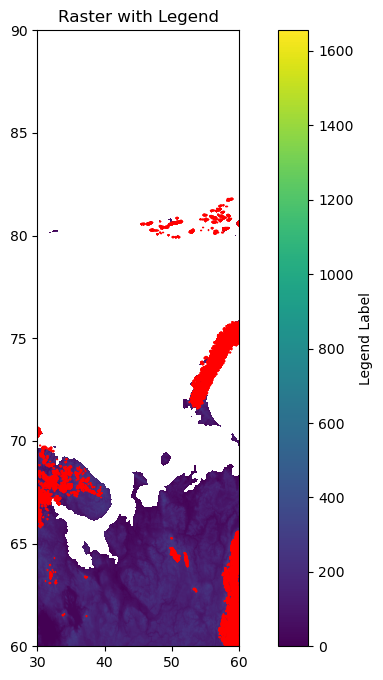

In [217]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Open the raster dataset
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1, masked=True)
    #raster_data = raster_data/np.sum(raster_data)
    # Plot the raster using imshow
    fig, ax = plt.subplots(figsize=(10, 8))
    img = ax.imshow(raster_data, cmap='viridis', extent=src.bounds, origin='upper')
    ax.set_title('Raster with Legend')

    # Add a colorbar as a legend
    cbar = plt.colorbar(img, ax=ax, orientation='vertical')
    cbar.set_label('Legend Label')  # Set the label for the colorbar
# Plot the GeoPandas polygons on top of the raster
polys.plot(ax=ax, facecolor='none', edgecolor='red')
plt.show()

# Grunnkart

In [ ]:
import arcpy

def grunnkartsammensling():
    # To allow overwriting outputs change overwriteOutput option to True.
    arcpy.env.overwriteOutput = False
    arcpy.env.parallelProcessingFactor = "90%"


    srcs = {
        'arealregnskap_18': "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\18_25833_arealregnskap_gdb.gdb\\arealregnskap_18",
        'arealregnskap_15': "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\15_25832_arealregnskap_gdb.gdb\\arealregnskap_15",
        "arealregnskap_31": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\31_25832_arealregnskap_gdb.gdb\\arealregnskap_31",
        "arealregnskap_33": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\33_25832_arealregnskap_gdb.gdb\\arealregnskap_33",
        "arealregnskap_34": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\34_25832_arealregnskap_gdb.gdb\\arealregnskap_34",
        "arealregnskap_39": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\39_25832_arealregnskap_gdb.gdb\\arealregnskap_39",
        "arealregnskap_40": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\40_25832_arealregnskap_gdb.gdb\\arealregnskap_40",
        "arealregnskap_42": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\42_25832_arealregnskap_gdb.gdb\\arealregnskap_42",
        "arealregnskap_4_": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\50_25832_arealregnskap_gdb.gdb\\arealregnskap",
        "arealregnskap_6_": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\55_25833_arealregnskap_gdb.gdb\\arealregnskap",
        "arealregnskap_7_": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\56_25835_arealregnskap_gdb.gdb\\arealregnskap"
    }

    for name, path in srcs.items():
        print(str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))+":"+name)
        # Process: Select Layer By Attribute (Select Layer By Attribute) (management)
        arealregnskap, Count = arcpy.management.SelectLayerByAttribute(in_layer_or_view=path, where_clause="arealdekke <> 'Hav'")

        # Process: Pairwise Dissolve (Pairwise Dissolve) (analysis)
        dissolved_output = f"G:\\temp\\endre\\outStandard.gdb\\{name}_d"
        try:
            print(str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))+":"+"         Geometri slås sammen")
            arcpy.analysis.PairwiseDissolve(in_features=arealregnskap, out_feature_class=dissolved_output, multi_part="MULTI_PART")
        except arcpy.ExecuteError:
            # If Pairwise Dissolve fails, repair geometry and try again
            print(str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))+":"+"         Geometri må reparareres")
            Repaired_Input_Features = arcpy.management.RepairGeometry(in_features=arealregnskap)[0]
            
            print(str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))+":"+"         Geometri slås sammen")
            arcpy.analysis.PairwiseDissolve(in_features=Repaired_Input_Features, out_feature_class=dissolved_output, multi_part="MULTI_PART")

        # Process: Merge (Merge) (management)
        #merged_output = "G:\\temp\\endre\\Standard.gdb\\arealregnskap_d_Merge"
        ##arcpy.management.Merge(inputs=[dissolved_output], output=merged_output, add_source="ADD_SOURCE_INFO")

if __name__ == '__main__':
    # Global Environment settings
    with arcpy.EnvManager(scratchWorkspace="G:\\temp\\endre\\Standard.gdb", workspace="G:\\temp\\endre\\Standard.gdb"):
        grunnkartsammensling()